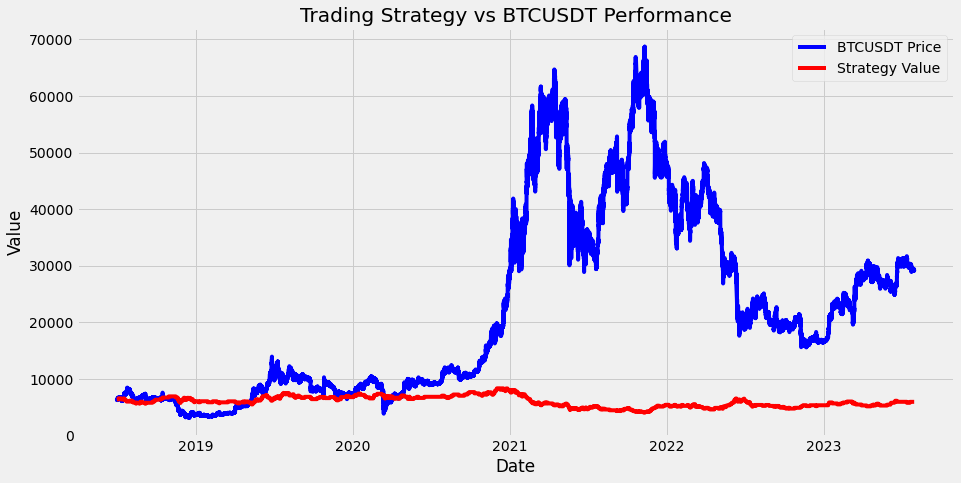

Total number of trades: 490
Success rate: 50.40816326530613%


In [26]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')


#Loading dataset
df = pd.read_csv("BTCUSDT_stock_data_test_5mins_5year.csv")

#Initialize variables
short_window = 50
long_window = 200
capital = df.loc[0, 'Close']
df['Portfolio_Value'] = capital
position = 0
entry_price = 0
stop_loss = 0
target = 0
num_trades = 0
num_successful_trades = 0

#Calculate moving averages
df['Short_MA'] = df['Close'].rolling(window=short_window).mean()
df['Long_MA'] = df['Close'].rolling(window=long_window).mean()

#Backtesting loop
for i in range(1, len(df)):
    short_ma = df.loc[i, 'Short_MA']
    long_ma = df.loc[i, 'Long_MA']
    prev_short_ma = df.loc[i - 1, 'Short_MA']
    prev_long_ma = df.loc[i - 1, 'Long_MA']
    close = df.loc[i, 'Close']

    if position == 0:
        if short_ma > long_ma and prev_short_ma <= prev_long_ma:
            risk_per_trade = 0.03 * capital
            entry_price = close
            position = 1
            stop_loss = entry_price * 0.95
            target = entry_price + (entry_price-stop_loss)
            num_trades += 1
            
        elif short_ma < long_ma and prev_short_ma >= prev_long_ma:
            risk_per_trade = 0.03 * capital
            entry_price = close
            position = -1
            stop_loss = entry_price * 1.05
            target = entry_price - (stop_loss-entry_price)
            num_trades += 1

    elif position == 1:
        if close >= target or close <= stop_loss:
            if close >= target:
                num_successful_trades += 1
                capital += risk_per_trade
                position = 0
            else:
                capital -= risk_per_trade
                position = 0
                

                
    elif position == -1:
        if close <= target or close >= stop_loss:
            if close <= target:
                num_successful_trades += 1
                capital += risk_per_trade
                position = 0
            else:
                capital -= risk_per_trade
                position = 0

    #Update Portfolio Value
    df.loc[i, 'Portfolio_Value'] = capital

#Plotting
plt.figure(figsize=(14, 7))
plt.plot(pd.to_datetime(df['Open Time']), df['Close'], label='BTCUSDT Price', color='b')
plt.plot(pd.to_datetime(df['Open Time']), df['Portfolio_Value'], label='Strategy Value', color='r')
plt.legend()
plt.title('Trading Strategy vs BTCUSDT Performance')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

#Calculate success rate
if num_trades > 0:
    success_rate = (num_successful_trades / num_trades) * 100
else:
    success_rate = 0

print(f'Total number of trades: {num_trades}')
print(f'Success rate: {success_rate}%')


In [20]:
def calculate_drawdowns(return_series):
    running_max = return_series.cummax()
    running_max[running_max < return_series.iloc[0]] = return_series.iloc[0]
    drawdown = (return_series / running_max) - 1
    return drawdown

def calculate_max_drawdown(drawdown_series):
    return drawdown_series.min() * 100  # returns max drawdown in percentage


In [21]:
#Calculate the returns for BTCUSDT
df['BTC_Returns'] = df['Close'].pct_change()
df['BTC_Returns'].fillna(0, inplace=True)

#Calculate cumulative returns
df['BTC_Cumulative_Returns'] = (1 + df['BTC_Returns']).cumprod()


In [22]:
#Calculate and plot drawdowns for Portfolio and BTCUSDT
portfolio_drawdown = calculate_drawdowns(df['Portfolio_Value'])
btcusdt_drawdown = calculate_drawdowns(df['BTC_Cumulative_Returns'] * df.loc[0, 'Close'])

#Calculate max drawdowns
max_portfolio_drawdown = calculate_max_drawdown(portfolio_drawdown)
max_btcusdt_drawdown = calculate_max_drawdown(btcusdt_drawdown)


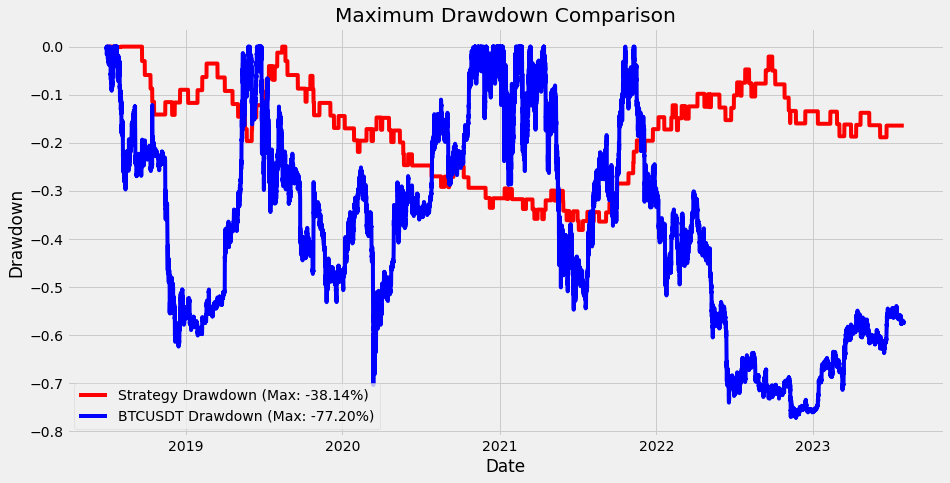

In [23]:
plt.figure(figsize=(14, 7))
plt.plot(pd.to_datetime(df['Open Time']), portfolio_drawdown, label=f'Strategy Drawdown (Max: {max_portfolio_drawdown:.2f}%)', color='r')
plt.plot(pd.to_datetime(df['Open Time']), btcusdt_drawdown, label=f'BTCUSDT Drawdown (Max: {max_btcusdt_drawdown:.2f}%)', color='b')
plt.title('Maximum Drawdown Comparison')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.legend()
plt.show()


In [24]:
#Calculate the final values
final_portfolio_value = df.loc[len(df) - 1, 'Portfolio_Value']
final_btc_price = df.loc[len(df) - 1, 'Close']

#Calculate the initial values
initial_portfolio_value = df.loc[0, 'Portfolio_Value']
initial_btc_price = df.loc[0, 'Close']

#Calculate the total percentage return for the trading strategy
portfolio_return_percentage = ((final_portfolio_value - initial_portfolio_value) / initial_portfolio_value) * 100

#Calculate the total percentage return for BTCUSDT buy-and-hold strategy
btc_return_percentage = ((final_btc_price - initial_btc_price) / initial_btc_price) * 100

print(f'Total percentage return of the trading strategy: {portfolio_return_percentage:.2f}%')
print(f'Total percentage return of the BTCUSDT buy-and-hold strategy: {btc_return_percentage:.2f}%')


Total percentage return of the trading strategy: -9.90%
Total percentage return of the BTCUSDT buy-and-hold strategy: 362.35%
